# Team 21 - AWS Supabase Hack

Shall you invest in big tech stocks? Which one to invest in? Let's find out with AI. Powered by AWS and Supabase!

### Use Case
We will use RAG to review the annual reports of big tech companies and then analyse the recent performance of the stock.

Based on our findings, make an investment decision!

### Team 21
A team passionate in AI.
- Bryan Ho bryan@bevootech.com
- Vivian Lim vivian@bevootech.com

### Pre-requisites

Before starting this lab, we need to load the variables that we stored in the previous notebook.

In [1]:
%store -r

In [2]:
agent_id

'QY8CAINARW'

Let's now import the necessary libraries and initiate the required boto3 clients

In [3]:
from knowledge_base import KnowledgeBasesForAmazonBedrock
from agent import invoke_agent_helper
import boto3
import os
import time
import json

In [4]:
iam_client = boto3.client('iam')
bedrock_agent_client = boto3.client('bedrock-agent')
bedrock_agent_runtime_client = boto3.client('bedrock-agent-runtime')
s3_client = boto3.client('s3')

In [13]:
knowledge_base_name = f'{agent_name}-kb'
knowledge_base_description = "Knowledge Base containing the 2023 Annual Report of Meta, Amazon and Apple"
bucket_name = f'{agent_name}-{suffix}'

In [14]:
kb = KnowledgeBasesForAmazonBedrock()
kb_id, ds_id = kb.create_or_retrieve_knowledge_base(knowledge_base_name, knowledge_base_description, bucket_name)

Knowledge Base booking-agent-kb already exists.
Retrieved Knowledge Base Id: KYKXQXFYTU
Retrieved Data Source Id: A63RWUDQSI


In [15]:
def upload_directory(path, bucket_name):
        for root,dirs,files in os.walk(path):
            for file in files:
                file_to_upload = os.path.join(root,file)
                print(f"uploading file {file_to_upload} to {bucket_name}")
                s3_client.upload_file(file_to_upload,bucket_name,file)

upload_directory("kb_documents", bucket_name)

uploading file kb_documents/Meta Annual Report 2023.pdf to booking-agent-us-west-2-183630321848
uploading file kb_documents/Amazon-com-Inc-2023-Annual-Report.pdf to booking-agent-us-west-2-183630321848
uploading file kb_documents/Apple Annual Report 2023.pdf to booking-agent-us-west-2-183630321848


In [16]:
# ensure that the kb is available
i_status = ['CREATING', 'DELETING', 'UPDATING']
while bedrock_agent_client.get_knowledge_base(knowledgeBaseId=kb_id)['knowledgeBase']['status'] in i_status:
    time.sleep(10)

# sync knowledge base
kb.synchronize_data(kb_id, ds_id)

{ 'dataSourceId': 'A63RWUDQSI',
  'ingestionJobId': 'WCWHDSAJLP',
  'knowledgeBaseId': 'KYKXQXFYTU',
  'startedAt': datetime.datetime(2024, 7, 12, 14, 38, 46, 795839, tzinfo=tzlocal()),
  'statistics': { 'numberOfDocumentsDeleted': 0,
                  'numberOfDocumentsFailed': 0,
                  'numberOfDocumentsScanned': 0,
                  'numberOfMetadataDocumentsModified': 0,
                  'numberOfMetadataDocumentsScanned': 0,
                  'numberOfModifiedDocumentsIndexed': 0,
                  'numberOfNewDocumentsIndexed': 0},
  'status': 'STARTING',
  'updatedAt': datetime.datetime(2024, 7, 12, 14, 38, 46, 795839, tzinfo=tzlocal())}
{ 'dataSourceId': 'A63RWUDQSI',
  'ingestionJobId': 'WCWHDSAJLP',
  'knowledgeBaseId': 'KYKXQXFYTU',
  'startedAt': datetime.datetime(2024, 7, 12, 14, 38, 46, 795839, tzinfo=tzlocal()),
  'statistics': { 'numberOfDocumentsDeleted': 0,
                  'numberOfDocumentsFailed': 0,
                  'numberOfDocumentsScanned': 9,
  

### Testing Knowledge Base

Let's now test that the created knowledge base works as expected. To do so, we first retrieve the knowledge base id

In [48]:
company_selector = widgets.Dropdown(
    options=[
        ('Amazon', 'Amazon'),
        ('Meta', 'Meta'),
        ('Apple', 'Apple')
    ],
    value='Amazon',
    description='Which company do you want to analyze? ',
    disabled=False,
)
company_selector

Dropdown(description='Which company do you want to analyze? ', options=(('Amazon', 'Amazon'), ('Meta', 'Meta')…

Next we can use the [`RetrieveAndGenerate`](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-agent-runtime/client/retrieve_and_generate.html) API from boto3 to retrieve the context for the question from the knowledge base and generate the final response

In [45]:
response = bedrock_agent_runtime_client.retrieve_and_generate(
    input={
        "text": f"Summarize the financial performance of {company_selector.value}. I need to make investment decisions."
    },
    retrieveAndGenerateConfiguration={
        "type": "KNOWLEDGE_BASE",
        "knowledgeBaseConfiguration": {
            'knowledgeBaseId': kb_id,
            "modelArn": "arn:aws:bedrock:{}::foundation-model/{}".format(region, agent_foundation_model),
            "retrievalConfiguration": {
                "vectorSearchConfiguration": {
                    "numberOfResults":20
                } 
            }
        }
    }
)

print(response['output']['text'],end='\n'*2)

Meta Platforms, Inc. (formerly Facebook) reported the following key financial results for 2023:

- Revenue: $134.9 billion (up 15.6% from 2022)
- Net income: $39.1 billion (up 68.3% from 2022)
- Operating income: $46.8 billion (up 61.5% from 2022)
- Earnings per share: $14.87 diluted (up 73.1% from 2022)

Meta generates substantially all of its revenue from advertising, primarily from its Family of Apps segment which includes Facebook, Instagram, WhatsApp, and Messenger. The company is investing heavily in building the metaverse and its Reality Labs segment focused on augmented and virtual reality products and services. While Meta's revenue and profits grew significantly in 2023, the company faces risks and challenges including:

- Increasing competition from other social media and advertising platforms
- Regulatory scrutiny and potential fines/restrictions around data privacy, content moderation, and antitrust issues
- Dependence on a small number of large digital advertising partners

In [144]:
import panel as pn
import uuid
session_id:str = str(uuid.uuid1())

pn.extension()

def callback(contents: str, user: str, instance: pn.chat.ChatInterface):
    response = bedrock_agent_runtime_client.retrieve_and_generate(
    input={
            "text": f"{contents}"
        },
        retrieveAndGenerateConfiguration={
            "type": "KNOWLEDGE_BASE",
            "knowledgeBaseConfiguration": {
                'knowledgeBaseId': kb_id,
                "modelArn": "arn:aws:bedrock:{}::foundation-model/{}".format(region, agent_foundation_model),
                "retrievalConfiguration": {
                    "vectorSearchConfiguration": {
                        "numberOfResults":20
                    } 
                }
            }
        }
    )
    message = response['output']['text']
    #message = (response['output']['text'],end='\n'*2)
    return message

chat_interface = pn.chat.ChatInterface(callback=callback, callback_user="System")
chat_interface.send("What do you want to know about Amazon, Meta and Apple?", user="System", respond=False)
chat_interface.servable()

ChatInterface(_button_data={'send': _ChatButtonData(i...}, _buttons={'send': Button(align='cen...}, _input_container=Row, _input_layout=Row, _placeholder=ChatMessage, _widgets={'ChatAreaInput': ChatArea...}, callback=<function callback a..., callback_user='System', show_button_name=True, sizing_mode='stretch_width', widgets=[ChatAreaInput(css_classes...])
    [0] ChatMessage(str, avatar='⚙️', reaction_icons=ChatReactionIcons, timestamp=datetime.datetime(2024, ..., user='System')

### Updating Agent role to allow Knowledge Base Retrieve and Retrieve and Generate queries

Now that our Knowledge Base is working, we will associate it with the agent. To do so, we first need to update the agent role to allow for retrieval from context from our knowledge base

In [25]:
kb_policies_statements = [
    {
        "Sid": "QueryKB",
        "Effect": "Allow",
        "Action": [
            "bedrock:Retrieve",
            "bedrock:RetrieveAndGenerate"
        ],
        "Resource": [
            f"arn:aws:bedrock:{region}:{account_id}:knowledge-base/{kb_id}"
        ]
    }
]
bedrock_agent_kb_policy_statement = {
    "Version": "2012-10-17",
    "Statement": kb_policies_statements
}
bedrock_agent_kb_policy_json = json.dumps(bedrock_agent_kb_policy_statement)
kb_policy_name = f"{agent_name}-kb-{kb_id}"
agent_kb_policy = iam_client.create_policy(
    PolicyName=kb_policy_name,
    PolicyDocument=bedrock_agent_kb_policy_json
)
iam_client.attach_role_policy(
    RoleName=agent_role['Role']['RoleName'],
    PolicyArn=agent_kb_policy['Policy']['Arn']
)

{'ResponseMetadata': {'RequestId': '22f947dd-00f5-47bb-b266-c50861bdc84c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Fri, 12 Jul 2024 14:47:50 GMT',
   'x-amzn-requestid': '22f947dd-00f5-47bb-b266-c50861bdc84c',
   'content-type': 'text/xml',
   'content-length': '212'},
  'RetryAttempts': 0}}

#### Associate Knowledge Base with Agent

Finally, we can associate the new knowledge base with the agent using the [`AssociateAgentKnowledgeBase`](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-agent/client/associate_agent_knowledge_base.html) API from boto3

In [26]:
#time.sleep(10)
response = bedrock_agent_client.associate_agent_knowledge_base(
    agentId=agent_id,
    agentVersion='DRAFT',
    description='Access the knowledge base when user ask about the business performance about Amazon, Meta or Apple.',
    knowledgeBaseId=kb_id,
    knowledgeBaseState='ENABLED'
)

#### Preparing Agent

after updating our agent, we need to prepare it again to package all its new components

In [27]:
response = bedrock_agent_client.prepare_agent(
    agentId=agent_id
)
print(response)
# Pause to make sure agent is prepared
intermediate_agent_status = ['CREATING', 'PREPARING', 'UPDATING', 'VERSIONING']
while bedrock_agent_client.get_agent(agentId=agent_id)['agent']['agentStatus'] in intermediate_agent_status:
    time.sleep(10)


{'ResponseMetadata': {'RequestId': '325cb5c9-b9f1-41ab-a970-2cebcecba7c4', 'HTTPStatusCode': 202, 'HTTPHeaders': {'date': 'Fri, 12 Jul 2024 14:48:44 GMT', 'content-type': 'application/json', 'content-length': '119', 'connection': 'keep-alive', 'x-amzn-requestid': '325cb5c9-b9f1-41ab-a970-2cebcecba7c4', 'x-amz-apigw-id': 'azdMAEGtPHcEgvg=', 'x-amzn-trace-id': 'Root=1-6691424c-08d3adb00e39c522268e3208'}, 'RetryAttempts': 0}, 'agentId': 'QY8CAINARW', 'agentStatus': 'PREPARING', 'agentVersion': 'DRAFT', 'preparedAt': datetime.datetime(2024, 7, 12, 14, 48, 44, 649937, tzinfo=tzlocal())}


### Invoking Agent

Now that our Agent has been updated, let's test it again. To do so we will again use the [`invoke_agent`](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-agent-runtime/client/invoke_agent.html) function from the boto3 Bedrock runtime client.

Now we can test it by asking a question where the answer is available in the knowledge base documents

Let's try this question in the input

How was Amazon's sales in 2023 vs Apple? Which is the better company to invest in?

In [46]:
questionforagent=input()

 How was Amazon's sales in 2023 vs Apple? Which is the better company to invest in?


In [130]:
pip install panel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 59.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 105.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.8/116.8 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.9/83.9 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 5.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [143]:
import panel as pn
import uuid
session_id:str = str(uuid.uuid1())

pn.extension()

def callback(contents: str, user: str, instance: pn.chat.ChatInterface):
    message = invoke_agent_helper(f"{contents}", session_id, agent_id, alias_id)
    return message

chat_interface = pn.chat.ChatInterface(callback=callback, callback_user="System")
chat_interface.send("What do you want to know about Amazon, Meta and Apple?", user="System", respond=False)
chat_interface.servable()

ChatInterface(_button_data={'send': _ChatButtonData(i...}, _buttons={'send': Button(align='cen...}, _input_container=Row, _input_layout=Row, _placeholder=ChatMessage, _widgets={'ChatAreaInput': ChatArea...}, callback=<function callback a..., callback_user='System', show_button_name=True, sizing_mode='stretch_width', widgets=[ChatAreaInput(css_classes...])
    [0] ChatMessage(str, avatar='⚙️', reaction_icons=ChatReactionIcons, timestamp=datetime.datetime(2024, ..., user='System')

In [137]:
%%time
import uuid
session_id:str = str(uuid.uuid1())
query = f"{questionforagent}"
response = invoke_agent_helper(query, session_id, agent_id, alias_id)
print(response)


According to the information from the knowledge base, Amazon had stronger business performance and revenue growth in 2023 compared to Apple. Amazon's total revenue grew by 12% year-over-year to $575 billion, while Apple's total net sales decreased by 3% to $383.3 billion. Amazon's operating income also improved significantly by 201% and its free cash flow increased substantially.
<sources>
5
</sources>



In contrast, Apple saw declines in sales for its key products like the iPhone and Mac, although its Services revenue grew by 9%. Based on the stronger revenue growth, improved profitability, and cash flow generation, Amazon appears to be the better company to invest in compared to Apple for 2023.
<sources>
1
3
</sources>

CPU times: user 21.3 ms, sys: 4.05 ms, total: 25.4 ms
Wall time: 12.2 s


### Let's analyze today's stock performance!

Find out how the stock is performing today

In [62]:
ticker_selector = widgets.Dropdown(
    options=[
        ('Amazon', 'AMZN'),
        ('Meta', 'META'),
        ('Apple', 'AAPL')
    ],
    value='AMZN',
    description='Which stock? ',
    disabled=False,
)
ticker_selector

Dropdown(description='Which stock? ', options=(('Amazon', 'AMZN'), ('Meta', 'META'), ('Apple', 'AAPL')), value…

In [64]:
import requests
import json
import os
import sys
import ipywidgets as widgets
import boto3

modelId = 'amazon.titan-text-express-v1'
accept = "application/json"
contentType = "application/json"

bedrock_runtime = boto3.client('bedrock-runtime')

apiurl = f"https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={ticker_selector.value}&apikey=NJ9WMAL3UVJE6OYK"

apiresponse = requests.get(apiurl)
data = apiresponse.json()

prompt_data = f"""Stock price data: {data}. Explain it in layman terms."""

body = json.dumps({
        "inputText": prompt_data,
        "textGenerationConfig": {
            "maxTokenCount": 500,
            "stopSequences": [],
            "temperature": 0.7,
            "topP": 0.9
        }
    })

try:
    response = bedrock_runtime.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    response_body = json.loads(response.get("body").read())
    for result in response_body['results']:
        print(f"{result['outputText']}")

except botocore.exceptions.ClientError as error:

    if error.response['Error']['Code'] == 'AccessDeniedException':
           print(f"\x1b[41m{error.response['Error']['Message']}\
                \nTo troubeshoot this issue please refer to the following resources.\
                 \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
                 \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")

    else:
        raise error


Here's the explanation of the stock price data in layman terms:

The stock price data represents the performance of a particular stock over time. It includes information such as the stock symbol, the opening price, the highest price, the lowest price, the closing price, the trading volume, and the latest trading day.

- The stock symbol is 'AAPL'.
- The opening price was $231.3900.
- The highest price was $232.3900.
- The lowest price was $225.7700.
- The closing price was $227.5700.
- The trading volume was 647,106,17.
- The latest trading day was July 11, 2024.
- The previous close price was $232.9800.
- The change is the difference between the closing price and the previous close price, which in this case is -$5.4100.
- The change percent is the percentage change in the stock price, calculated by dividing the change by the previous close price and multiplying by 100. In this case, the change percent is -2.3221%.

So, the stock price of 'AAPL' closed at $227.5700 on July 11, 2024, w

### Should I buy more?

Let's analyse the last 30 days results and decide!

In [68]:
import requests
import json
import os
import sys
import ipywidgets as widgets
import boto3

apiurl = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={ticker_selector.value}&apikey=NJ9WMAL3UVJE6OYK&outputsize=compact "
apiresponse = requests.get(apiurl)
data = apiresponse.json()

time_series_daily = data['Time Series (Daily)']
last_30_days_data = dict(list(time_series_daily.items())[:30])
#print(json.dumps(last_30_days_data, indent=4))

prompt_data = f"""Act as an expert stock trader and financial advisor, based on the stock price data of {company_selector.value} over the last 30 days, tell me your analysis and whether I should buy or sell today. Data: {last_30_days_data}"""

body = json.dumps({
        "inputText": prompt_data,
        "textGenerationConfig": {
            "maxTokenCount": 2000,
            "stopSequences": [],
            "temperature": 0.7,
            "topP": 0.9
        }
    })

modelId = 'amazon.titan-text-express-v1'
accept = "application/json"
contentType = "application/json"

bedrock_runtime = boto3.client('bedrock-runtime')

try:
    response = bedrock_runtime.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    response_body = json.loads(response.get("body").read())
    for result in response_body['results']:
        print(f"{result['outputText']}")

except botocore.exceptions.ClientError as error:

    if error.response['Error']['Code'] == 'AccessDeniedException':
           print(f"\x1b[41m{error.response['Error']['Message']}\
                \nTo troubeshoot this issue please refer to the following resources.\
                 \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
                 \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")

    else:
        raise error


Based on the provided stock price data of Amazon over the last 30 days, I can provide you with an analysis and my recommendation on whether to buy or sell today.

Overall, the stock price of Amazon has experienced some fluctuations but has generally been trending upwards. The recent high of $233.08 on July 10 and the low of $225.77 on July 11 indicate a moderate range of movement.

To analyze the trend more closely, we can look at the moving averages. The 5-day moving average for Amazon is $226.93, while the 20-day moving average is $224.91. These moving averages suggest that the stock price has been consolidating in the recent past and is currently trading in a range between $224.91 and $226.93.

Based on this analysis, it is difficult to make a clear recommendation on whether to buy or sell Amazon stock today. If you are looking for a long-term investment, the stock's trend suggests that it may be a good time to buy, as the price is currently in a consolidation phase and may continu

### Ask about the stock data

Let AI find the trend for you

In [145]:
import panel as pn
import uuid
session_id:str = str(uuid.uuid1())

pn.extension()

def callback(contents: str, user: str, instance: pn.chat.ChatInterface):
    message = invoke_agent_helper(f"{contents}. Stock Data: {last_30_days_data}", session_id, agent_id, alias_id)
    return message

chat_interface = pn.chat.ChatInterface(callback=callback, callback_user="System")
chat_interface.send("What do you want to know about the stock data?", user="System", respond=False)
chat_interface.servable()

ChatInterface(_button_data={'send': _ChatButtonData(i...}, _buttons={'send': Button(align='cen...}, _input_container=Row, _input_layout=Row, _placeholder=ChatMessage, _widgets={'ChatAreaInput': ChatArea...}, callback=<function callback a..., callback_user='System', show_button_name=True, sizing_mode='stretch_width', widgets=[ChatAreaInput(css_classes...])
    [0] ChatMessage(str, avatar='⚙️', reaction_icons=ChatReactionIcons, timestamp=datetime.datetime(2024, ..., user='System')

### A final surprise

Select gender, age range, dress code and ethnicity

In [74]:
gender_selector = widgets.Dropdown(
    options=[
        ('Male', 'Male'),
        ('Female', 'Female')
    ],
    value='Male',
    description='Gender',
    disabled=False,
)
gender_selector

Dropdown(description='Gender', options=(('Male', 'Male'), ('Female', 'Female')), value='Male')

In [75]:
age_range = widgets.Dropdown(
    options=[
        ('18 to 28', '18 to 28'),
        ('29 to 38', '29 to 38'),
        ('39 to 48', '39 to 48'),
        ('49 to 58', '49 to 58'),
        ('59 to 68', '59 to 68'),
        ('69 to 78', '69 to 78')
    ],
    value='18 to 28',
    description='Age',
    disabled=False,
)
age_range

Dropdown(description='Age', options=(('18 to 28', '18 to 28'), ('29 to 38', '29 to 38'), ('39 to 48', '39 to 4…

In [76]:
dress_code = widgets.Dropdown(
    options=[
        ('Casual', 'Casual'),
        ('Dressy Casual', 'Dressy Casual'),
        ('Semi-formal', 'Semi-formal'),
        ('Business Formal', 'Business Formal'),
        ('Business Casual', 'Business Casual'),
        ('Black Tie', 'Black Tie'),
        ('Creative Black Tie', 'Creative Black Tie'),
        ('Festive Attire', 'Festive Attire'),
        ('White Tie', 'White Tie')
    ],
    value='Casual',
    description='Dress Code',
    disabled=False,
)
dress_code

Dropdown(description='Dress Code', options=(('Casual', 'Casual'), ('Dressy Casual', 'Dressy Casual'), ('Semi-f…

In [128]:
skin_tone = widgets.Dropdown(
    options=[
        ('Asian', 'Asian'),
        ('American Indian', 'American Indian'),
        ('Black', 'Black'),
        ('Native Hawaiian', 'Native Hawaiian'),
        ('White', 'White')
    ],
    value='Asian',
    description='Ethnicity',
    disabled=False,
)
skin_tone

Dropdown(description='Ethnicity', options=(('Asian', 'Asian'), ('American Indian', 'American Indian'), ('Black…

In [81]:
pip install supabase

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 20.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [125]:
#enter supabase url
supabase_url=widgets.Password(
    value='',
    placeholder='Enter your Supabase url',
    description='Supabase url:',
    disabled=False
)
supabase_url

Password(description='Supabase url:', placeholder='Enter your Supabase url')

In [126]:
#enter supabase key
supabase_key=widgets.Password(
    value='',
    placeholder='Enter your Supabase key',
    description='Supabase key:',
    disabled=False
)
supabase_key

Password(description='Supabase key:', placeholder='Enter your Supabase key')

Output: iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAIAAADwf7zUAAEAAElEQVR4nEz9245lSZIsiImIqq3t7hGZ...


[2024-07-12 23:23:50,653] p550 {_client.py:1026} INFO - HTTP Request: GET https://cmmbdmiqcucznukdmjtd.supabase.co/storage/v1/bucket "HTTP/1.1 200 OK"


[]


[2024-07-12 23:23:53,325] p550 {_client.py:1026} INFO - HTTP Request: POST https://cmmbdmiqcucznukdmjtd.supabase.co/storage/v1/object/awssupa/1720826629.png "HTTP/1.1 200 OK"


Upload Response: <Response [200 OK]>
Unexpected response format: <Response [200 OK]>


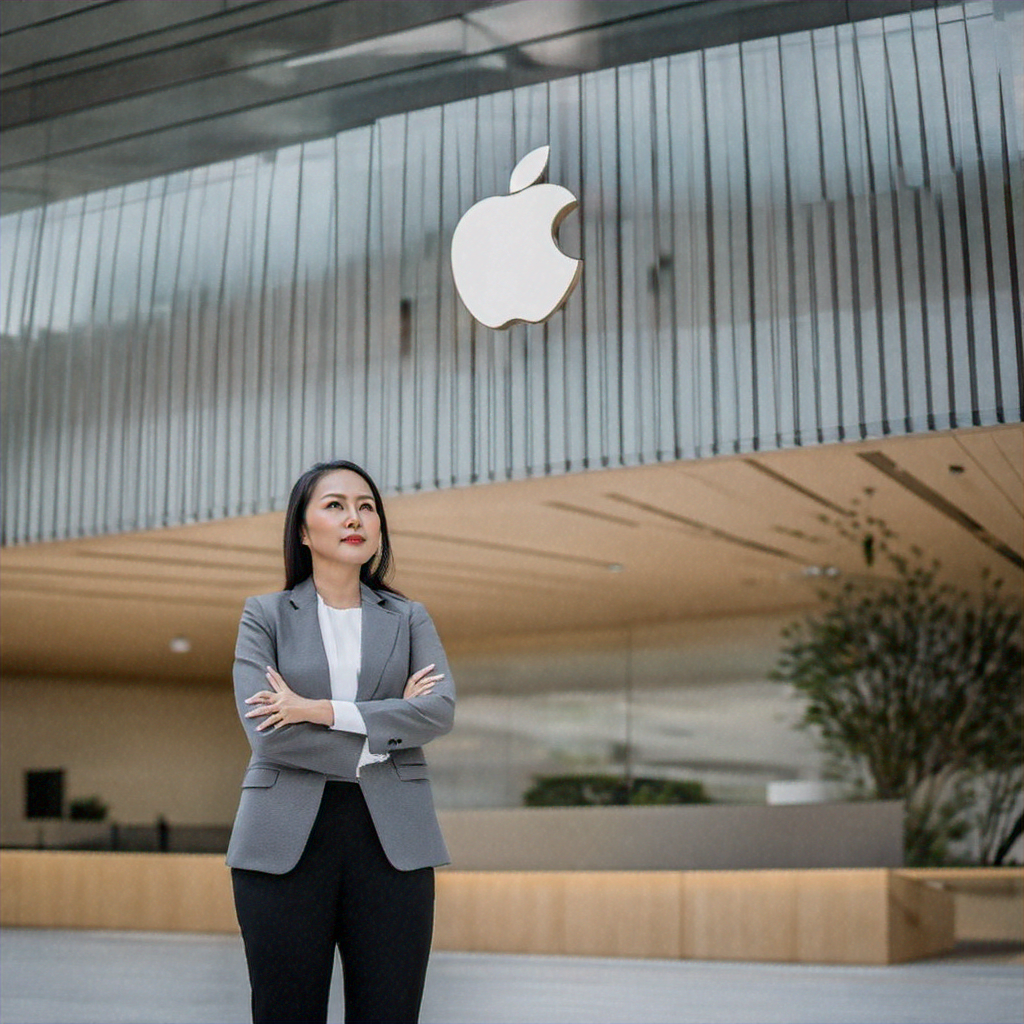

In [127]:
# Built-in libraries
import base64
import io
import json
import os
import sys

# External dependencies
import boto3
from PIL import Image
import botocore
from supabase import create_client, Client
import random

from datetime import datetime

boto3_bedrock = boto3.client('bedrock-runtime')

prompt = f"a good looking {skin_tone.value} {gender_selector.value} around the age range of {age_range.value} wearing {dress_code.value} standing proud at the office building of {company_selector.value}. The image have text caption of a motivation quote about being successful."
negative_prompts = "poorly rendered, poor background details, poorly drawn building, disfigured facial features"

# Create payload
body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": prompt,                    # Required
            "negativeText": negative_prompts   # Optional
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,   # Range: 1 to 5 
            "quality": "standard",  # Options: standard or premium
            "height": 1024,        # Supported height list in the docs 
            "width": 1024,         # Supported width list in the docs
            "cfgScale": 7.5,       # Range: 1.0 (exclusive) to 10.0
            "seed": random.randint(0, 214783647)             # Range: 0 to 214783647
        }
    }
)

# Make model request
response = boto3_bedrock.invoke_model(
    body=body,
    modelId="amazon.titan-image-generator-v1",
    accept="application/json", 
    contentType="application/json"
)

# Process the image
response_body = json.loads(response.get("body").read())
img1_b64 = response_body["images"][0]

# Debug
print(f"Output: {img1_b64[0:80]}...")

os.makedirs("data/titan", exist_ok=True)

# Decode + save
img1 = Image.open(
    io.BytesIO(
        base64.decodebytes(
            bytes(img1_b64, "utf-8")
        )
    )
)
img1.save(f"data/titan/image_1.png")

#save to supabase
supaurl = supabase_url.value
supakey = supabase_key.value
supabase = create_client(supaurl, supakey)

# Path to the file you want to upload
file_path = 'data/titan/image_1.png'
bucket_name = 'awssupa'
file_name = os.path.basename(file_path)

curr_dt = datetime.now()
timestamp = int(round(curr_dt.timestamp()))
file_name = f'{timestamp}.png'


# Verify bucket name
bucketlist = supabase.storage.list_buckets()
print(bucketlist)

# Read the file content
with open(file_path, 'rb') as file:
    file_content = file.read()

# Ensure file content is not empty
if not file_content:
    raise ValueError("File content is empty. Please check the file path and content.")

# Upload the file to Supabase Storage
response = supabase.storage.from_(bucket_name).upload(file_name, file_content)

# Print the response to understand its structure
print("Upload Response:", response)

# Check for an error in the response
if isinstance(response, dict) and 'error' in response:
    print("Error uploading file:", response['error'])
elif isinstance(response, dict) and 'data' in response:
    print("File uploaded successfully:", response['data'])
else:
    print("Unexpected response format:", response)


# Display
img1

In [29]:
%store kb_id
%store knowledge_base_name
%store knowledge_base_description
%store kb_policy_name
%store bucket_name
%store knowledge_base_name

Stored 'kb_id' (str)
Stored 'knowledge_base_name' (str)
Stored 'knowledge_base_description' (str)
Stored 'kb_policy_name' (str)
Stored 'bucket_name' (str)
Stored 'knowledge_base_name' (str)
